In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
file_dir = os.path.join(os.getcwd(),'spatial-lstm','sensor_data','interpolated_data')
adcp = []
for i in range(1,5):
    file_name = 'ADCP_Sensor_'+str(i)+'.csv'
    file_path = os.path.join(file_dir,file_name)
    df = pd.read_csv(file_path, parse_dates=True, index_col="observed_timestamp")
    df[np.isnan(df)]=-1 # mask the missing values
    adcp.append(df['value'])
    print(df.index.min(),df.index.max()) # Check timestamp

2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00
2019-01-01 00:00:00 2019-12-31 23:30:00


In [3]:
df = pd.DataFrame(adcp).transpose()
df.head()

,value,value,value,value
observed_timestamp,,,,
2019-01-01 00:00:00,28.274415,9.636717,25.353515,19.801758
2019-01-01 00:30:00,27.239258,12.173828,30.364747,18.477539
2019-01-01 01:00:00,27.541013,12.520508,26.920409,19.249998
2019-01-01 01:30:00,29.662109,12.282225,31.734375,18.083008
2019-01-01 02:00:00,32.172850,13.845703,36.116213,17.734374


In [4]:
df.columns = ['ADCP_Sensor_1', 'ADCP_Sensor_2', 'ADCP_Sensor_3', 'ADCP_Sensor_4']

In [5]:
df.head()

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4
observed_timestamp,,,,
2019-01-01 00:00:00,28.274415,9.636717,25.353515,19.801758
2019-01-01 00:30:00,27.239258,12.173828,30.364747,18.477539
2019-01-01 01:00:00,27.541013,12.520508,26.920409,19.249998
2019-01-01 01:30:00,29.662109,12.282225,31.734375,18.083008
2019-01-01 02:00:00,32.172850,13.845703,36.116213,17.734374


In [6]:
len(df.loc['2019-01-01'])

48

<AxesSubplot:xlabel='observed_timestamp'>

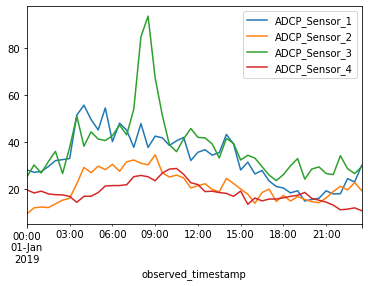

In [7]:
df.loc['2019-01-01'].plot()

<AxesSubplot:xlabel='observed_timestamp'>

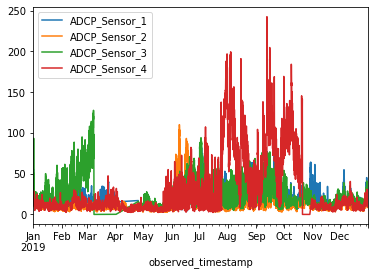

In [8]:
df.plot()

In [9]:
print(df.shape)

(17520, 4)


In [10]:
# df = df.resample(rule='D').mean()
# print(df.shape)

In [11]:
# df.plot()

In [12]:
# Percentage of data for testing
test_percent = 0.01

# No. of test points
test_points= np.round(len(df)*test_percent)

# Test Cut off point (index value)
test_ind = int(len(df)-test_points)

print(test_percent, test_points, test_ind)

0.01 175.0 17345


In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
print(train.shape, test.shape)
print(type(train), type(test))

(17345, 4) (175, 4)
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [16]:
print(scaled_train.shape, scaled_test.shape)
print(type(scaled_train), type(scaled_test))

(17345, 4) (175, 4)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# length of input sequence in number of timesteps (number of input samples to produce one output)
length = 175
# Number of timeseries samples in each batch
batch_size = 1
# No.of features
n_features = 4

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=length, 
                                batch_size=batch_size)

In [19]:
print(len(scaled_train),len(generator))
len(scaled_train)-len(generator) # lenght given by us

17345 17170


175

In [20]:
X, y = generator[0]

In [21]:
print(X.shape, y.shape)

(1, 175, 4) (1, 4)


In [22]:
# (1, 36, 4) --> (batch_size, length, n_features)
# (1, 4) --> (1, n_features)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional

In [24]:
model = Sequential()
model.add(SimpleRNN(units=length, input_shape=(length,n_features))) # input_shape=(36,4)
model.add(Dense(units=4))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 175)               31500     
                                                                 
 dense (Dense)               (None, 4)                 704       
                                                                 
Total params: 32,204
Trainable params: 32,204
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit_generator(generator, epochs=5)

Epoch 1/5


C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\3367823435.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=5)


17170/17170 [==============================] - 140s 8ms/step - loss: 0.0050
Epoch 2/5
17170/17170 [==============================] - 137s 8ms/step - loss: 0.0032
Epoch 3/5
17170/17170 [==============================] - 138s 8ms/step - loss: 0.0030
Epoch 4/5
17170/17170 [==============================] - 137s 8ms/step - loss: 0.0035
Epoch 5/5
17170/17170 [==============================] - 137s 8ms/step - loss: 0.0033


<AxesSubplot:>

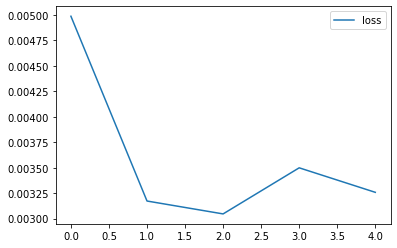

In [26]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [27]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


In [28]:
true_pred = scaler.inverse_transform(test_pred)

In [29]:
test[['RNN_1','RNN_2','RNN_3','RNN_4']] = true_pred
test.head()

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\3932421098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['RNN_1','RNN_2','RNN_3','RNN_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\3932421098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['RNN_1','RNN_2','RNN_3','RNN_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\3932421098.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4,RNN_1,RNN_2,RNN_3,RNN_4
observed_timestamp,,,,,,,,
2019-12-28 08:30:00,18.655274,10.429806,20.150389,13.786135,20.996784,0.927155,27.954517,20.313190
2019-12-28 09:00:00,17.136720,10.812695,18.695312,13.067384,24.235711,-16.706358,36.752619,38.270155
2019-12-28 09:30:00,20.732423,11.612298,18.008790,14.673827,28.597820,-33.986431,44.237260,61.765810
2019-12-28 10:00:00,19.927733,12.375106,16.991212,16.629883,32.363739,-45.982152,45.931329,79.829358
2019-12-28 10:30:00,19.773439,11.984292,16.032715,16.074217,34.616529,-52.019326,44.506234,89.500825


Text(0.5, 1.0, 'ADCP_Sensor_4')

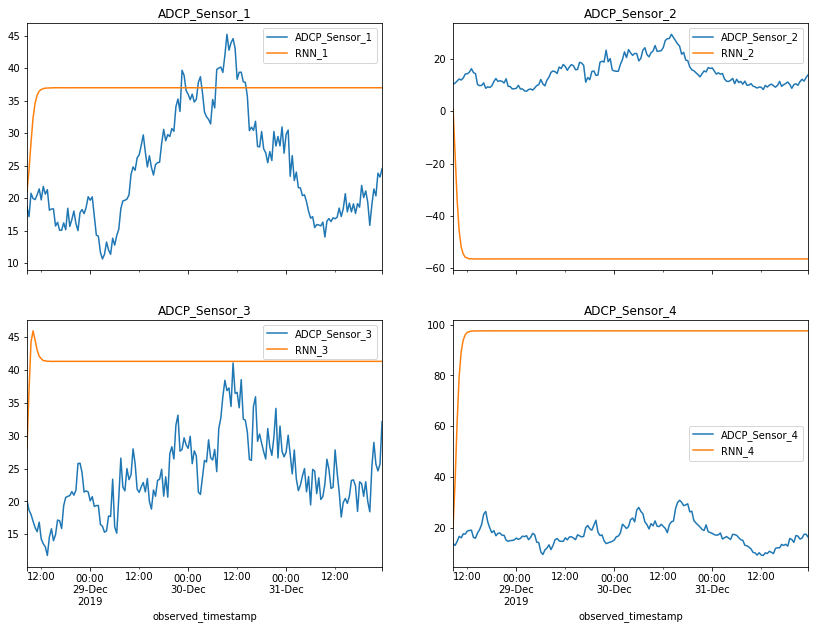

In [30]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,10))

test.filter(regex='_1',axis=1).plot(ax=axes[0,0])
axes[0,0].set_title('ADCP_Sensor_1')

test.filter(regex='_2',axis=1).plot(ax=axes[0,1])
axes[0,1].set_title('ADCP_Sensor_2')

test.filter(regex='_3',axis=1).plot(ax=axes[1,0])
axes[1,0].set_title('ADCP_Sensor_3')

test.filter(regex='_4',axis=1).plot(ax=axes[1,1])
axes[1,1].set_title('ADCP_Sensor_4')

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [33]:
# length of input sequence in number of timesteps (number of input samples to produce one output)
length = length-1
# Number of timeseries samples in each batch
batch_size = 1

generator = TimeseriesGenerator(data=scaled_train, 
                                targets=scaled_train, 
                                length=length, 
                                batch_size=batch_size)

val_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test, length=length, batch_size=1)

In [34]:
model = Sequential()
model.add(LSTM(units=length, input_shape=(length,n_features))) # input_shape=(35,4)
model.add(Dense(units=4))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 174)               124584    
                                                                 
 dense_1 (Dense)             (None, 4)                 700       
                                                                 
Total params: 125,284
Trainable params: 125,284
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\3917464766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])


17171/17171 [==============================] - 384s 22ms/step - loss: 0.0014 - val_loss: 0.0011


In [36]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [37]:
len(test_pred)

175

In [38]:
true_pred = scaler.inverse_transform(test_pred)

In [39]:
test[['LSTM_1','LSTM_2','LSTM_3','LSTM_4']] = true_pred
test.head()

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\4007027690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['LSTM_1','LSTM_2','LSTM_3','LSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\4007027690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['LSTM_1','LSTM_2','LSTM_3','LSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\4007027690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4,RNN_1,RNN_2,RNN_3,RNN_4,LSTM_1,LSTM_2,LSTM_3,LSTM_4
observed_timestamp,,,,,,,,,,,,
2019-12-28 08:30:00,18.655274,10.429806,20.150389,13.786135,20.996784,0.927155,27.954517,20.313190,18.238987,11.822290,19.980537,10.687753
2019-12-28 09:00:00,17.136720,10.812695,18.695312,13.067384,24.235711,-16.706358,36.752619,38.270155,17.285566,11.943141,18.754454,8.337682
2019-12-28 09:30:00,20.732423,11.612298,18.008790,14.673827,28.597820,-33.986431,44.237260,61.765810,16.412324,12.099235,17.724285,6.590233
2019-12-28 10:00:00,19.927733,12.375106,16.991212,16.629883,32.363739,-45.982152,45.931329,79.829358,15.688218,12.212017,16.800119,5.067224
2019-12-28 10:30:00,19.773439,11.984292,16.032715,16.074217,34.616529,-52.019326,44.506234,89.500825,15.081671,12.289869,15.954838,3.665799


Text(0.5, 1.0, 'ADCP_Sensor_4')

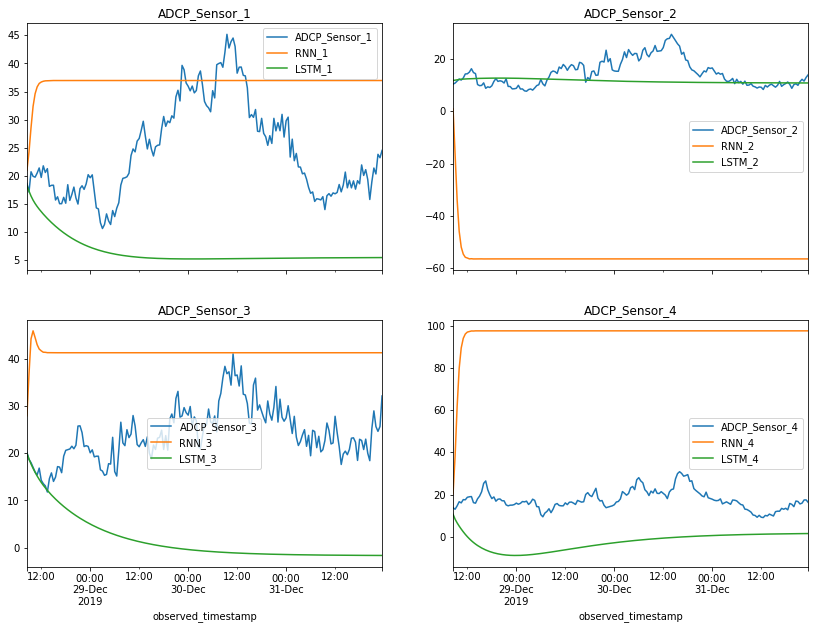

In [40]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,10))

test.filter(regex='_1',axis=1).plot(ax=axes[0,0])
axes[0,0].set_title('ADCP_Sensor_1')

test.filter(regex='_2',axis=1).plot(ax=axes[0,1])
axes[0,1].set_title('ADCP_Sensor_2')

test.filter(regex='_3',axis=1).plot(ax=axes[1,0])
axes[1,0].set_title('ADCP_Sensor_3')

test.filter(regex='_4',axis=1).plot(ax=axes[1,1])
axes[1,1].set_title('ADCP_Sensor_4')

In [41]:
# define stacked LSTM model
model_stacked = Sequential()
model_stacked.add(Bidirectional(LSTM(length, activation='relu'), input_shape=(length, n_features)))
model_stacked.add(Dense(n_features))
model_stacked.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 174)               124584    
                                                                 
 dense_1 (Dense)             (None, 4)                 700       
                                                                 
Total params: 125,284
Trainable params: 125,284
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])

    4/17171 [..............................] - ETA: 6:17 - loss: 0.0011

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\3917464766.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=generator, validation_data=val_generator, callbacks=[early_stop])


17171/17171 [==============================] - 384s 22ms/step - loss: 0.0011 - val_loss: 0.0011


In [43]:
test_pred = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(scaled_test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


In [44]:
len(test_pred)

175

In [45]:
true_pred = scaler.inverse_transform(test_pred)

In [46]:
test[['BiLSTM_1','BiLSTM_2','BiLSTM_3','BiLSTM_4']] = true_pred
test.head()

C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\1982142649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['BiLSTM_1','BiLSTM_2','BiLSTM_3','BiLSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\1982142649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['BiLSTM_1','BiLSTM_2','BiLSTM_3','BiLSTM_4']] = true_pred
C:\Users\AKSHAYA\AppData\Local\Temp\ipykernel_5144\1982142649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

,ADCP_Sensor_1,ADCP_Sensor_2,ADCP_Sensor_3,ADCP_Sensor_4,RNN_1,RNN_2,RNN_3,RNN_4,LSTM_1,LSTM_2,LSTM_3,LSTM_4,BiLSTM_1,BiLSTM_2,BiLSTM_3,BiLSTM_4
observed_timestamp,,,,,,,,,,,,,,,,
2019-12-28 08:30:00,18.655274,10.429806,20.150389,13.786135,20.996784,0.927155,27.954517,20.313190,18.238987,11.822290,19.980537,10.687753,18.243734,11.102346,20.012362,8.944316
2019-12-28 09:00:00,17.136720,10.812695,18.695312,13.067384,24.235711,-16.706358,36.752619,38.270155,17.285566,11.943141,18.754454,8.337682,16.857831,10.448429,19.276066,5.755021
2019-12-28 09:30:00,20.732423,11.612298,18.008790,14.673827,28.597820,-33.986431,44.237260,61.765810,16.412324,12.099235,17.724285,6.590233,15.738075,9.983529,18.454262,2.748727
2019-12-28 10:00:00,19.927733,12.375106,16.991212,16.629883,32.363739,-45.982152,45.931329,79.829358,15.688218,12.212017,16.800119,5.067224,14.789290,9.581281,17.525147,0.070671
2019-12-28 10:30:00,19.773439,11.984292,16.032715,16.074217,34.616529,-52.019326,44.506234,89.500825,15.081671,12.289869,15.954838,3.665799,13.951285,9.219127,16.526572,-2.284828


Text(0.5, 1.0, 'ADCP_Sensor_4')

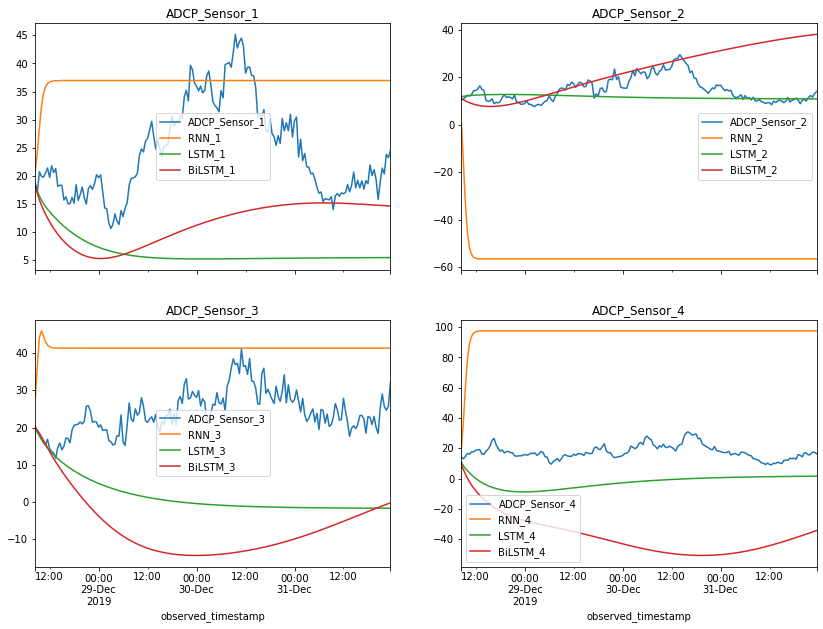

In [47]:
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(14,10))

test.filter(regex='_1',axis=1).plot(ax=axes[0,0])
axes[0,0].set_title('ADCP_Sensor_1')

test.filter(regex='_2',axis=1).plot(ax=axes[0,1])
axes[0,1].set_title('ADCP_Sensor_2')

test.filter(regex='_3',axis=1).plot(ax=axes[1,0])
axes[1,0].set_title('ADCP_Sensor_3')

test.filter(regex='_4',axis=1).plot(ax=axes[1,1])
axes[1,1].set_title('ADCP_Sensor_4')